In [1]:
#Python
import os
import random
import datetime
from math import log10, sqrt

#Numpy
import numpy as np

#Pandas
import pandas as pd

#Matplot
import matplotlib.pyplot as plt

#sklearn
#import sklearn as sk
#from sklearn.manifold import Isomap # for Isomap dimensionality reduction
#from sklearn.model_selection import train_test_split

#CV2
import cv2 as cv2

#Tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import img_to_array


In [2]:
#=========================================#
#                Paramètres               #
#=========================================#
TOTAL_IMAGE=2025
SIZE=256 #Size of dataset

PATH_DATASET="../imageupscale_ia_dataset/" #Path dataset

POURCENTAGE_TRAIN=0.8
POURCENTAGE_VALIDATION=0.1

#Color
HIGH_COLOUR="green"
LOW_COLOUR="red"
PREDICTED_COLOUR="yellow"

VERSION=4

In [5]:
#===============================================#
#      Charge/Convertie/Enregistre Datasets     #
#===============================================#
#Chargement des images d'un repertoire dans un tableau dans une taille passé en parametre
def LoadAndResizeImg(size,allPath):
    imgTab= []
    for path in allPath:
        files = os.listdir(path)
        for i in files:
            img = cv2.imread(path+'/'+i, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (size, size))
            img = img.astype('float32') / 255.0
            imgTab.append(img)
    return imgTab


low_res=np.array(LoadAndResizeImg(SIZE,[PATH_DATASET+'dataset1/low/',PATH_DATASET+'dataset2/low_res/',PATH_DATASET+'/dataset3/low/']))
high_res=np.array(LoadAndResizeImg(SIZE,[PATH_DATASET+'dataset1/high/',PATH_DATASET+'dataset2/high_res/',PATH_DATASET+'dataset3/high/']))

#Enregistrement des datasets
np.save('./dataset/high_res_x256.npy', high_res)
np.save('./dataset/low_res_x256.npy', low_res)

In [3]:
#===========================#
#      Charge Datasets      #
#===========================#
high_res=np.load('./dataset/high_res_x256.npy')
low_res=np.load('./dataset/low_res_x256.npy')

#Vérifier le chargements
print('Taille donnée de test High :',high_res.shape)
print('Taille donnée de test Low :',low_res.shape)
if(high_res.shape==low_res.shape and high_res.shape[0]==TOTAL_IMAGE):
    print("Tout a été bien charger !")
else :
    print("Problème lors du chargement")

Taille donnée de test High : (2025, 256, 256, 3)
Taille donnée de test Low : (2025, 256, 256, 3)
Tout a été bien charger !


In [191]:
#Fonction qui prend une séquence de "number" images à partir d'un endroit aléatoire du tableau et les affiches
def showRandomPics(low,high,number):
    j = random.randint(0, len(low)-number)
    for i in range(0,number):
        plt.subplot(1,2,1)
        plt.title('Low Image', color = LOW_COLOUR, fontsize = 18)
        plt.imshow((low[j+i] * 255).astype(np.uint8))
        plt.subplot(1,2,2)
        plt.title('High Image', color = HIGH_COLOUR, fontsize = 18)
        plt.imshow(high[j+i])
        plt.show()
#showRandomPics(low_res,high_res,10)

In [4]:
#============================#
#       Split Datasets       #
#============================#

#Fonction qui sépare les images en trois tableau : Train, Validation, Test
def splitAndReshapeDataset(dataSet, pourcentageTrain, pourcentageValidation):
    #Vérification des paramètres
    help="Un ratio Train=0.5 Validation=0.2 est possible"
    if pourcentageTrain+pourcentageValidation > 1:
        print("La sommes des pourcentages dépasse 1 !\n",help)
        return NULL
    elif pourcentageTrain+pourcentageValidation == 1:
        print("Il ne reste plus aucune images pour tester l'IA, apprend a faire des maths !",help)
        return NULL
    
    
    #Calcule indice (nombre d'image)
    nbImages=dataSet.shape[0]
    nbTrain = int(nbImages*pourcentageTrain)
    nbValidate = int(nbImages*pourcentageValidation)
    
    #split des images en 3 tableaux
    Train=dataSet[0:nbTrain] #Dataset[O=>Train]
    Validate=dataSet[nbTrain:nbTrain+nbValidate] #Dataset[Train=>Validation]
    Test=dataSet[nbTrain+nbValidate:nbImages] #Dataset[Validation=>Fin]
    
    #reshape
    Train = np.reshape(Train,(len(Train),SIZE,SIZE,3))
    Validate = np.reshape(Validate,(len(Validate),SIZE,SIZE,3))
    Test = np.reshape(Test,(len(Test),SIZE,SIZE,3))
    
    return Train,Validate,Test


#Répartition des images
train_low_res, val_low_res, test_low_res = splitAndReshapeDataset(low_res,POURCENTAGE_TRAIN,POURCENTAGE_VALIDATION) 
train_high_res, val_high_res, test_high_res = splitAndReshapeDataset(high_res,POURCENTAGE_TRAIN,POURCENTAGE_VALIDATION)

print("Répartition :")
print("Nombre d'image de train    :",train_low_res.shape[0],"(",round(POURCENTAGE_TRAIN*100),"%)")
print("Nombre d'image de validate :",val_low_res.shape[0]," (",round(POURCENTAGE_VALIDATION*100),"%)")
print("Nombre d'image de test     :",test_low_res.shape[0]," (",round((1-(POURCENTAGE_TRAIN+POURCENTAGE_VALIDATION))*100),"%)")

Répartition :
Nombre d'image de train    : 1620 ( 80 %)
Nombre d'image de validate : 202  ( 10 %)
Nombre d'image de test     : 203  ( 10 %)


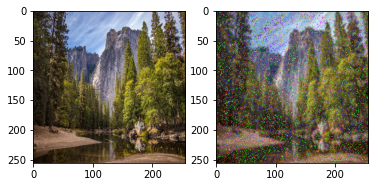

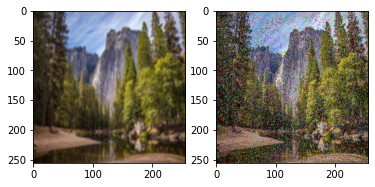

In [6]:
#====================================#
#       Test dégradation image       #
#====================================#
def showImgInLine(tab):
    i=1
    for img in tab :
        plt.subplot(1,len(tab),i)
        plt.imshow(img)
        i=i+1
    plt.show()
    
def apply_noise(img,size,force):
    if force>1 :
        print("La force doit être en dessous de 1\nExemple: 0.2 ")
        return NULL
    noise = np.random.normal(0,1,img.size)#gauss noise
    noise = noise.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
    img = img + img * (noise*force)
    return (img * 255).astype(np.uint8)

def caca(tab):
    tab2=[]
    for img in tab:
        img=apply_noise(img,SIZE,0.02) #noise
        img=cv2.blur(img,(10,10)) #blur
        tab2.append(img)
    return tab2

img=train_low_res[6]
#img => noise => blur => blur+noise
blur=cv2.blur(img,(3,4))
noise=apply_noise(img,SIZE,0.02)
both=apply_noise(blur,SIZE,0.02)
showImgInLine([img,both])
showImgInLine([blur,noise])

In [7]:
#On applique sur la partie de train du dataset
train_low_res=caca(train_low_res)

In [116]:
#=========================================#
#              IA V1 ISOMAP               #
#=========================================#

#Premier approche avec sklearn => ECHEC
#Modèle d'approximation du kernel : Isomap Dimensionality Reduction
"""
def model_shape(tabImg): #(number of images, height, width, channel) to (number of images, channels* height* width)
    a_shape=tabImg.shape
    return tabImg.reshape(a_shape[0],a_shape[1]*a_shape[2]*a_shape[3])

X=model_shape(low_res)
Y=model_shape(high_res)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y,test_size=0.25, random_state=0)

model=Isomap(n_components=2)
model.fit(Xtrain,Ytrain)

from sklearn.metrics import accuracy_score
ypredict=model.transform(Xtest)
print(ypredict.shape)
"""

'\ndef model_shape(tabImg): #(number of images, height, width, channel) to (number of images, channels* height* width)\n    a_shape=tabImg.shape\n    return tabImg.reshape(a_shape[0],a_shape[1]*a_shape[2]*a_shape[3])\n\nX=model_shape(low_res)\nY=model_shape(high_res)\nXtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y,test_size=0.25, random_state=0)\n\nmodel=Isomap(n_components=2)\nmodel.fit(Xtrain,Ytrain)\n\nfrom sklearn.metrics import accuracy_score\nypredict=model.transform(Xtest)\nprint(ypredict.shape)\n'

In [48]:
#=========================================#
#      IA V2 Dimensionality Reduction     #
#=========================================#
#Modèle d'approximation du kernel : Dimensionality Reduction

def down(filters, kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [256,256,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)
    
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u2 = up(256,(3,3),False)(u1)
    u3 = up(128,(3,3),False)(u2)
    u4 = up(128,(3,3),False)(u3)
    u5 = up(3,(3,3),False)(u4)
    
    #concatenate
    u1 = layers.concatenate([u1,d4])
    u2 = layers.concatenate([u2,d3])    
    u3 = layers.concatenate([u3,d2])    
    u4 = layers.concatenate([u4,d1])
    u5 = layers.concatenate([u5,inputs])
    
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['acc'])

In [140]:
#=========================================#
#              Entrainement               #
#=========================================#
model.fit(train_low_res, train_high_res, epochs = 7, batch_size = 1, validation_data = (val_low_res, val_high_res))

2021-12-15 17:07:38.714103: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1274019840 exceeds 10% of free system memory.
2021-12-15 17:07:39.168065: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1274019840 exceeds 10% of free system memory.
2021-12-15 17:07:47.145026: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-15 17:07:47.192579: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3000000000 Hz


Epoch 1/7
1620/1620 [==============================] - ETA: 0s - loss: 3.2061 - acc: 0.3988

2021-12-15 17:10:05.370989: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 158859264 exceeds 10% of free system memory.
2021-12-15 17:10:05.418108: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 158859264 exceeds 10% of free system memory.


1620/1620 [==============================] - 143s 88ms/step - loss: 3.2061 - acc: 0.3988 - val_loss: 0.0997 - val_acc: 0.3885
Epoch 2/7
1620/1620 [==============================] - 140s 86ms/step - loss: 0.1105 - acc: 0.4727 - val_loss: 0.0732 - val_acc: 0.3572
Epoch 3/7
1620/1620 [==============================] - 141s 87ms/step - loss: 0.1049 - acc: 0.4975 - val_loss: 0.0775 - val_acc: 0.4870
Epoch 4/7
1620/1620 [==============================] - 140s 86ms/step - loss: 0.1039 - acc: 0.5056 - val_loss: 0.0746 - val_acc: 0.6923
Epoch 5/7
1620/1620 [==============================] - 144s 89ms/step - loss: 0.1006 - acc: 0.5246 - val_loss: 0.1063 - val_acc: 0.4684
Epoch 6/7
1620/1620 [==============================] - 142s 87ms/step - loss: 0.1021 - acc: 0.5265 - val_loss: 0.0813 - val_acc: 0.6266
Epoch 7/7
1620/1620 [==============================] - 140s 86ms/step - loss: 0.1039 - acc: 0.5236 - val_loss: 0.1119 - val_acc: 0.5851


In [269]:
#=========================================#
#           Sauvegarde du model           #
#=========================================#
#Version correspond à la version de l'ia
#Créer un dossier avec pour nom la version de l'ia
def create_folder_essaie(version):
    nb=0
    if(version==None):
        nb=len(os.listdir("essaie/"))+1
    else :
        nb=version
    folder="essaie/essaie n"+str(nb)
    os.mkdir(folder)
    return folder
#Sauvegarde le model dans le bon dossier
def save_model(model,version):
    folder=create_folder_essaie(version)
    x = datetime.datetime.now()
    name=x.strftime("%d%m%y_%H%M")+"00"
    model.save(folder+"/"+name+".h5")
    
#Sauvegarde le modèle de l'IA
save_model(model,VERSION)

In [8]:
#=========================================#
#           Chargement du model           #
#=========================================#
#model=tf.keras.models.load_model('essaie/essaie n1/model_v1.h5')
#model=tf.keras.models.load_model('essaie/essaie n2/model_v2.h5')
model=tf.keras.models.load_model('essaie/essaie n3/model_v3.h5')

<Figure size 432x288 with 0 Axes>

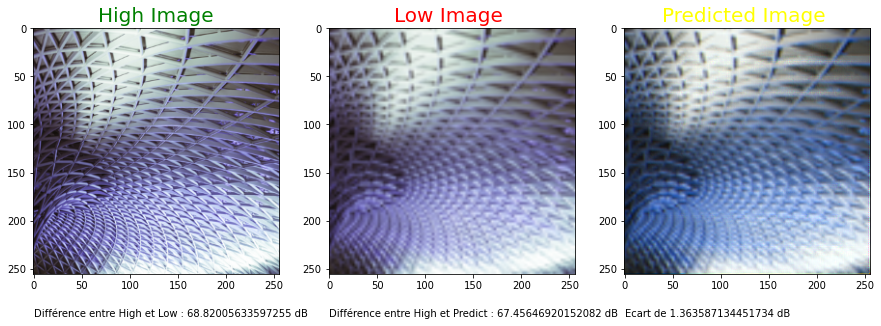

<Figure size 432x288 with 0 Axes>

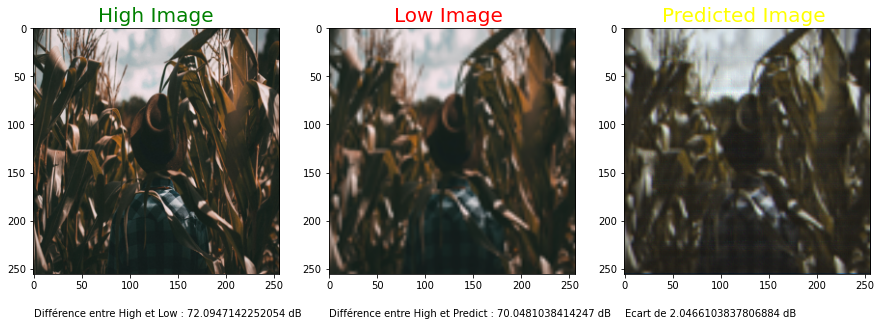

<Figure size 432x288 with 0 Axes>

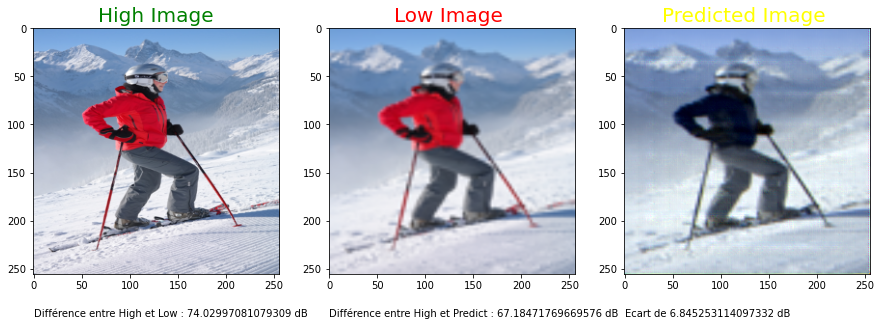

<Figure size 432x288 with 0 Axes>

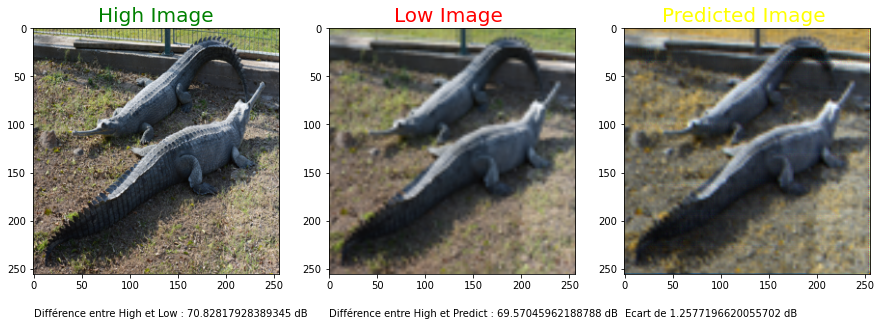

<Figure size 432x288 with 0 Axes>

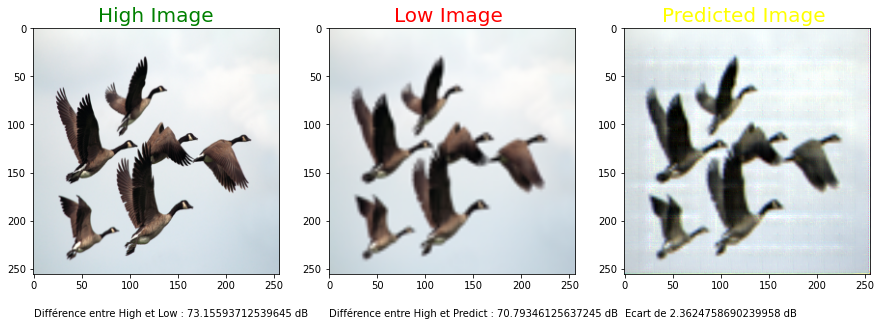

<Figure size 432x288 with 0 Axes>

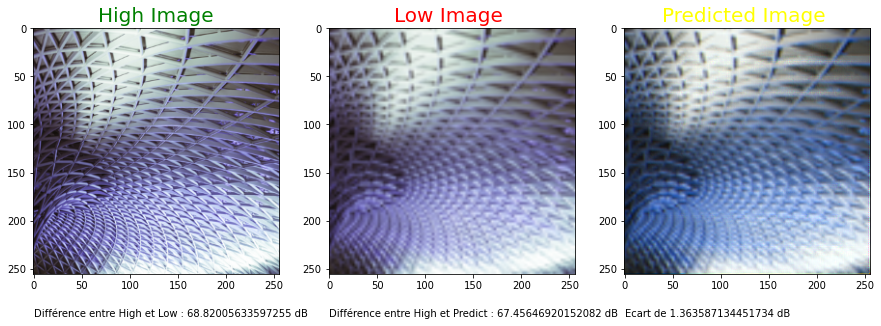

<Figure size 432x288 with 0 Axes>

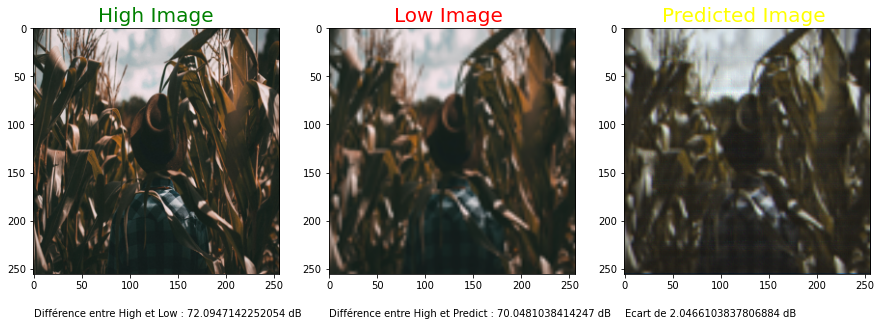

<Figure size 432x288 with 0 Axes>

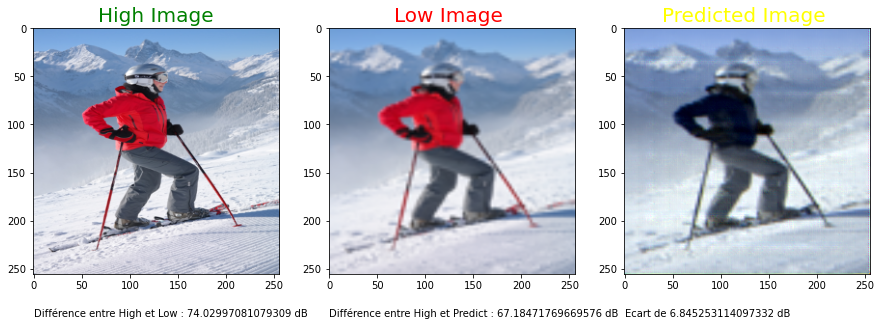

<Figure size 432x288 with 0 Axes>

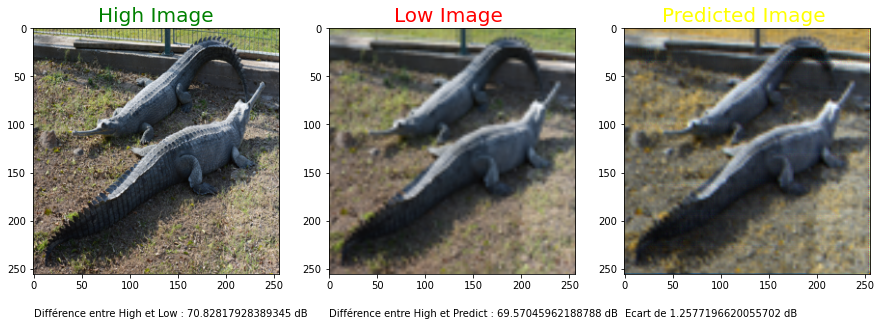

<Figure size 432x288 with 0 Axes>

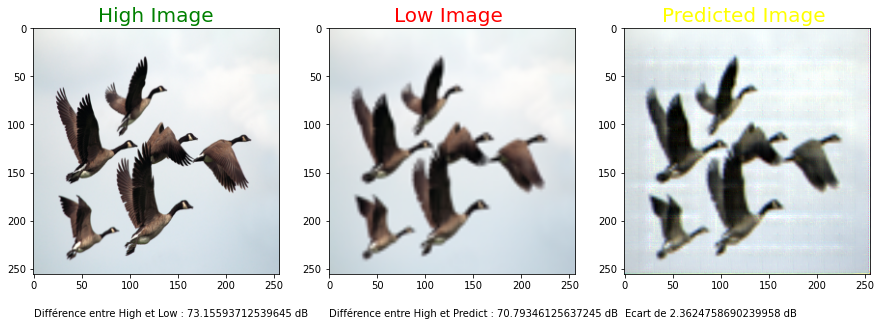

In [9]:
#=========================================#
#           Prediction du model           #
#=========================================#
#Prédit un certain nombre d'image à partir d'un tableau d'image en mauvaise qualité et donne un tableau avec High/Low/Predit
def predict(low,high,number):
    tab=[]
    j = random.randint(0, len(low)-number)
    for i in range(0,number):
        predicted = np.clip(model.predict(low[i+j].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
        tab.append([low[i+j],high[i+j],predicted])
    return tab

#PSNR est une mesure de distorsion utilisée en image numérique
#Il s'agit de quantifier la performance des codeurs en mesurant la qualité de reconstruction de l'image compressée par rapport à l'image originale.
def PSNR(original, predict): #Plus la valeur est haute, plus la différence entre les images est minimal
    mse = np.mean((original - predict) ** 2)
    if(mse == 0):  # Si le MSE est a 0, cela signifie qu'il n'y a aucune modification
        return 100
    return 20 * log10(255.0 / sqrt(mse))

#Prépare l'affichage des résultats
def fig_diff_predicted(low,high,predicted):
    PSNR1=PSNR(high, low)
    PSNR2=PSNR(high, predicted)
    HL="Différence entre High et Low : "+str(PSNR1)+" dB"
    HP="Différence entre High et Predict : "+str(PSNR2)+" dB"
    Ecart="Ecart de "+str(PSNR1-PSNR2)+" dB"
    
    fig=plt.figure()
    
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = HIGH_COLOUR, fontsize = 20)
    plt.imshow(high)
    plt.text(0,300,HL)
    
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = LOW_COLOUR, fontsize = 20)
    plt.imshow(low)
    plt.text(0,300,HP)
    
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = PREDICTED_COLOUR, fontsize = 20)
    plt.imshow(predicted)
    plt.text(0,300,Ecart)

    return fig

#Sauvegarde les figures
def figs_save(imgs,version):
    i=0
    folder="essaie/essaie n"+str(version)
    if not os.path.isdir(folder):
        folder=create_folder_essaie(version)
    for low,high,predict in imgs:
        t=fig_diff_predicted(low,high,predict)
        plt.savefig(folder+"/"+str(i)+".png")
        i=i+1

#Prédire les images
imgs_predict=predict(test_low_res,test_high_res,5)

#Préparer les figures et les afficher
for low,high,predict in imgs_predict:
    fig=fig_diff_predicted(low,high,predict)
    plt.show()
    
#Sauvegarder les figures
figs_save(imgs_predict,3)